In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTest import *
from backtest.regression_portfolio import *

from factor_mining.Mark0 import * # This is alpha file

In [2]:
%%time
### universe setup ###
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
univ = univ_setup(datadir, version=5, wFund=True)
filt_na(univ)

# import warnings
# warnings.filterwarnings("ignore")

Setup R3000 universe
use existing binary file
CPU times: user 2.74 s, sys: 196 ms, total: 2.93 s
Wall time: 2.93 s


In [3]:
%%time
### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_wFund_00(univ)

factor_names = list(factors.keys())
factors_dict = factors
factor_names = [k for k in factors_dict.keys()]
N_f = len(factor_names)
datelst = sorted(factors_dict[factor_names[0]].keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

Calculate factors
CPU times: user 54 s, sys: 788 ms, total: 54.8 s
Wall time: 54.8 s


In [4]:
### Filt the universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
# filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'volume', 300000)
filt_byval(univ, 'div_ratio', 10, keep='below')

factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1'])
print('Done')

# Preprocessing factor expsure matrices
print('Standard scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Filt the untradables
Done
Standard scale each factor
Winsorize with +/- 3 std
Done


In [5]:
%%time
start_date = np.datetime64('2014-01-01')
end_date = np.datetime64('2014-01-31')

factor_names = list(factors.keys())
spcalc = RegressionPtflSpcalc(all_factor_names=factor_names, smoothing='simple')
bt = BackTest(univ=univ, factor_exp_mat=factor_exp_mat, daterange=[start_date, end_date], sp_calc=spcalc, rebal=1)
ptfl_lst, pnl_lst = bt.calc_pnl(silence=True, has_short=True)

2014-01-07T00:00:00.000000000
2014-01-14T00:00:00.000000000
2014-01-21T00:00:00.000000000
2014-01-28T00:00:00.000000000
CPU times: user 5min 8s, sys: 4.08 s, total: 5min 12s
Wall time: 2min 37s


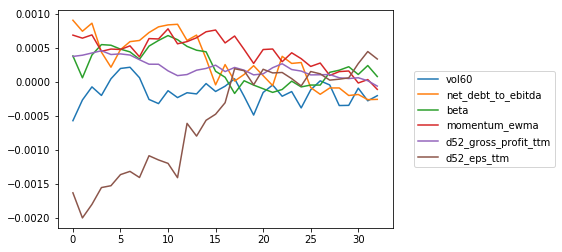

In [6]:
fr_series = np.stack(fr['factor_returns'] for fr in spcalc.all_factor_returns.values())
window = 30
ck = np.ones((window,)) / window
for c in range(6):
    fr_series[:,c] = np.convolve(ck, fr_series[:,c])[window-1:]
    plt.plot(fr_series[:,c], label=spcalc.all_factor_names[c])
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

In [7]:
bt.calc_pa(silent=False)

CAGR :	 -0.997240486734
Volatility :	 0.0540283826356
Sharpe :	 -109.066766025
Max_Drawdown :	 0.192872218737
Drawdown_Length :	 4


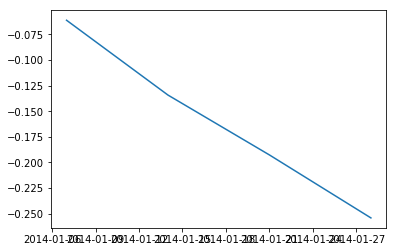

In [8]:
dlst = sorted(univ.keys())
dlst = [d for d in dlst if d >= start_date and d <= end_date]
plt.plot(dlst, np.cumsum(pnl_lst['pnl']))
plt.show()

In [9]:
tstamp = str(datetime.now())
bt.pnl_lst.to_csv('output/pnl_%s.csv' % tstamp)

In [10]:
ptfl_lst = pd.concat(bt.ptfl_lst)
pp = pd.pivot_table(ptfl_lst, values='weight', columns='ticker', index='date')
pp.to_csv('output/portfolio_table_%s.csv' % tstamp)